## Homework #1 Part III

Karahan Sarıtaş \
6661689

In [8]:
!pip install datasets
!pip install accelerate

You should consider upgrading via the 'C:\Users\karab\Desktop\Understanding LLMs\Homeworks\env\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\karab\Desktop\Understanding LLMs\Homeworks\env\Scripts\python.exe -m pip install --upgrade pip' command.


In [9]:
# note: if you are on Colab, you might need to install some requirements
# as we did in Sheet 1.1. Otherwise, don't forget to activate your local environment

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2Tokenizer, GPT2LMHeadModel
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### Additionals (just for data exploration)
import pprint

c:\Users\karab\Desktop\Understanding LLMs\Homeworks\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# download dataset from HF
dataset = load_dataset("tau/commonsense_qa")

In [11]:
# inspect dataset
print(dataset.keys())
# print a sample from the dataset

example = dataset['train'][5]
print("---"*10 + "\n" + "Sample from training set:")
pprint.pprint(example)
example = dataset['test'][5]
print("---"*10 + "\n" + "Sample from test set:")
pprint.pprint(example)

dict_keys(['train', 'validation', 'test'])
------------------------------
Sample from training set:
{'answerKey': 'D',
 'choices': {'label': ['A', 'B', 'C', 'D', 'E'],
             'text': ['radio shack',
                      'substation',
                      'cabinet',
                      'television',
                      'desk']},
 'id': 'e8a8b3a2061aa0e6d7c6b522e9612824',
 'question': 'What home entertainment equipment requires cable?',
 'question_concept': 'cable'}
------------------------------
Sample from test set:
{'answerKey': '',
 'choices': {'label': ['A', 'B', 'C', 'D', 'E'],
             'text': ['neighborhood',
                      'town',
                      'street',
                      'office building',
                      'city']},
 'id': '0b7734f608c188350573247e3ef2a00d',
 'question': 'After graduating the dentist set up his dental office back where '
             'he grew up, he wanted to always live in his home what?',
 'question_concept': 'dental of

In [12]:
len(dataset['train']), len(dataset['test'])

(9741, 1140)

In [193]:
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
# set padding side to be left because we are doing causal LM
tokenizer.padding_side = "left"

# pad token = A special token used to make arrays of tokens the same size for batching purpose. Will then be ignored by attention mechanisms or loss computation.

In [194]:
def massage_input_text(example):
    """
    Helper for converting input examples which have
    a separate question, labels, answer options
    into a single string.

    Arguments
    ---------
    example: dict
        Sample input from the dataset which contains the
        question, answer labels (e.g. A, B, C, D),
        the answer options for the question, and which
        of the answers is correct.

    Returns
    -------
    input_text: str
        Formatted training text which contains the question,
        the formatted answer options (e.g., 'A. <option 1> B. <option 2>' etc)
        and the ground truth answer.
    """
    # combine each label with its corresponding text
    answer_options_list = list(zip(
        example["choices"]["label"],
        example["choices"]["text"]
    ))
    # join each label and text with . and space
    answer_options = [". ".join([label, text]) for label, text in answer_options_list]
    # join the list of options with spaces into single string
    answer_options_string = " ".join(answer_options)
    # combine question and answer options
    input_text = example["question"] + " " + answer_options_string
    # append the true answer with a new line, "Answer: " and the label
    input_text += "\nAnswer: " + example["answerKey"]

    return input_text

# process input texts of train and test sets
massaged_datasets = dataset.map(
    lambda example: {
        "text": massage_input_text(example)
    }
)


In [195]:
# inspect a sample from our preprocessed data
massaged_datasets["train"][0]

{'id': '075e483d21c29a511267ef62bedc0461',
 'question': 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?',
 'question_concept': 'punishing',
 'choices': {'label': ['A', 'B', 'C', 'D', 'E'],
  'text': ['ignore', 'enforce', 'authoritarian', 'yell at', 'avoid']},
 'answerKey': 'A',
 'text': 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change? A. ignore B. enforce C. authoritarian D. yell at E. avoid\nAnswer: A'}

In [196]:
print(massaged_datasets)
train_split = massaged_datasets['train']['text']

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'question_concept', 'choices', 'answerKey', 'text'],
        num_rows: 9741
    })
    validation: Dataset({
        features: ['id', 'question', 'question_concept', 'choices', 'answerKey', 'text'],
        num_rows: 1221
    })
    test: Dataset({
        features: ['id', 'question', 'question_concept', 'choices', 'answerKey', 'text'],
        num_rows: 1140
    })
})


In [197]:
train_split[:5]

['The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change? A. ignore B. enforce C. authoritarian D. yell at E. avoid\nAnswer: A',
 'Sammy wanted to go to where the people were.  Where might he go? A. race track B. populated areas C. the desert D. apartment E. roadblock\nAnswer: B',
 'To locate a choker not located in a jewelry box or boutique where would you go? A. jewelry store B. neck C. jewlery box D. jewelry box E. boutique\nAnswer: A',
 'Google Maps and other highway and street GPS services have replaced what? A. united states B. mexico C. countryside D. atlas E. oceans\nAnswer: D',
 'The fox walked from the city into the forest, what was it looking for? A. pretty flowers. B. hen house C. natural habitat D. storybook E. dense forest\nAnswer: C']

In [198]:
# hyperparameters
MAX_LENGTH = 64
BATCH_SIZE = 32
EPOCHS = 1
NUM_TEST_STEPS = 5
LR = 5e-4

In [199]:
class CommonsenseQADataset(Dataset):
    """
    Custom dataset class for CommonsenseQA dataset.
    """

    def __init__(
            self,
            train_split,
            test_split,
            tokenizer,
            max_length=MAX_LENGTH,
            dataset_split="train",
        ) -> None:
        """
        Initialize the dataset object.

        Arguments
        ---------
        train_split: dict
            Training data dictionary with different columns.
        test_split: dict
            Test data dictionary with different columns.
        tokenizer: Tokenizer
            Initialized tokenizer for processing samples.
        max_length: int
            Maximal length of inputs. All inputs will be
            truncated or padded to this length.
        dataset_split: str
            Specifies which split of the dataset to use.
            Default is "train".
        """
        self.train_split = train_split['text']
        self.test_split = test_split['text']
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.dataset_split = dataset_split

    def __len__(self):
        """
        Method returning the length of the dataset.
        """
        return len(self.train_split) if self.dataset_split == "train" else len(self.test_split)

    def __getitem__(self, idx):
        """
        Method returning a single training example.
        Note that it also tokenizes, truncates or pads the input text.
        Further, it creates a mask tensor for the input text which
        is used for causal masking in the transformer model.

        Arguments
        ---------
        idx: int
            Index of training sample to be retrieved from the data.

        Returns
        --------
        tokenized_input: dict
            Dictionary with input_ids (torch.Tensor) and an attention_mask
            (torch.Tensor).
        """
        # retrieve a training sample at the specified index idx
        # HINT: note that this might depend on self.dataset_split
        input_text = self.train_split[idx] if self.dataset_split == "train" else self.test_split[idx]
        tokenized_input = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        tokenized_input["attention_mask"] = (tokenized_input["input_ids"] != tokenizer.pad_token_id).long()
        return tokenized_input

In [200]:
# move to accelerated device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Device: {device}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Device: {device}")
else:
    device = torch.device("cpu")
    print(f"Device: {device}")

Device: cuda


In [201]:
# 2. init model

# load pretrained gpt2 for HF
model = AutoModelForCausalLM.from_pretrained("gpt2")
# print num of trainable parameters
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 124.4M parameters


In [202]:
# 3. set up configurations required for the training loop

# instantiate dataset with the downloaded commonsense_qa data
train_dataset = CommonsenseQADataset(
    train_split=massaged_datasets["train"],
    test_split=massaged_datasets["test"],
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    dataset_split="train"
)
# instantiate test dataset with the downloaded commonsense_qa data
test_dataset = CommonsenseQADataset(
    train_split=massaged_datasets["train"],
    test_split=massaged_datasets["test"],
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    dataset_split="test"
)
# create a DataLoader for the dataset
# the data loader will automatically batch the data
# and iteratively return training examples (question answer pairs) in batches
dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
# create a DataLoader for the test dataset
# reason for separate data loader is that we want to
# be able to use a different index for retreiving the test batches
# we might also want to use a different batch size etc.
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [203]:
# 4. run the training of the model
# Hint: for implementing the forward pass and loss computation, carefully look at the exercise sheets
# and the links to examples in HF tutorials.

# put the model in training mode
model.train()
# move the model to the device (e.g. GPU)
model = model.to(device)

# trianing configutations
# feel free to play around with these
epochs  = EPOCHS
train_steps = len(train_dataset) // BATCH_SIZE
print("Number of training steps: ", train_steps)
# number of test steps to perform every 10 training steps
# (smaller that the entore test split for reasons of comp. time)
num_test_steps = NUM_TEST_STEPS

# define optimizer and learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
# define some variables to accumulate the losses
losses = []
test_losses = []

# iterate over epochs
for e in range(epochs):
    # iterate over training steps
    for i in tqdm(range(train_steps)):
        # get a batch of data
        x = next(iter(dataloader))
        # move the data to the device (GPU)
        x = x.to(device)

        # forward pass through the model
        ### YOUR CODE HERE ###
        outputs = model(
            input_ids=x["input_ids"],
            attention_mask=x["attention_mask"],
            labels=x["input_ids"]
        )
        # get the loss
        loss = outputs.loss
        # backward pass
        loss.backward()
        losses.append(loss.item())
        # update the parameters of the model
        optimizer.step()

        # zero out gradient for next step
        optimizer.zero_grad()

        # evaluate on test set every 10 steps
        if i % 10 == 0:
            print(f"Epoch {e}, step {i}, loss {loss.item()}")
            # track test loss for the evaluation iteration
            test_loss = 0
            for j in range(num_test_steps):
                # get test batch
                x_test = next(iter(test_dataloader))
                x_test = x_test.to(device)
                with torch.no_grad():
                    test_outputs = model(
                        input_ids=x_test["input_ids"],
                        attention_mask=x_test["attention_mask"],
                        labels=x_test["input_ids"]
                    )
                test_loss += test_outputs.loss.item()

            test_losses.append(test_loss / num_test_steps)
            print("Test loss: ", test_loss/num_test_steps)

Number of training steps:  304


  0%|          | 0/304 [00:00<?, ?it/s]

Epoch 0, step 0, loss 8.430136680603027


  0%|          | 1/304 [00:01<07:29,  1.48s/it]

Test loss:  9.823072814941407


  3%|▎         | 10/304 [00:06<02:43,  1.80it/s]

Epoch 0, step 10, loss 2.791978120803833


  4%|▎         | 11/304 [00:07<04:08,  1.18it/s]

Test loss:  2.6841872215270994


  7%|▋         | 20/304 [00:12<02:42,  1.75it/s]

Epoch 0, step 20, loss 2.337411403656006


  7%|▋         | 21/304 [00:14<04:08,  1.14it/s]

Test loss:  2.2052660465240477


 10%|▉         | 30/304 [00:19<02:32,  1.80it/s]

Epoch 0, step 30, loss 1.8503544330596924


 10%|█         | 31/304 [00:20<03:56,  1.15it/s]

Test loss:  2.013463592529297


 13%|█▎        | 40/304 [00:25<02:32,  1.73it/s]

Epoch 0, step 40, loss 1.9480000734329224


 13%|█▎        | 41/304 [00:27<03:43,  1.18it/s]

Test loss:  1.8774001598358154


 16%|█▋        | 50/304 [00:32<02:17,  1.85it/s]

Epoch 0, step 50, loss 1.8315768241882324


 17%|█▋        | 51/304 [00:33<03:24,  1.24it/s]

Test loss:  1.8499488830566406


 20%|█▉        | 60/304 [00:38<02:11,  1.86it/s]

Epoch 0, step 60, loss 1.7577944993972778


 20%|██        | 61/304 [00:39<03:15,  1.24it/s]

Test loss:  1.8674168348312379


 23%|██▎       | 70/304 [00:44<02:05,  1.86it/s]

Epoch 0, step 70, loss 1.5936130285263062


 23%|██▎       | 71/304 [00:45<03:06,  1.25it/s]

Test loss:  1.7969208002090453


 26%|██▋       | 80/304 [00:50<01:59,  1.88it/s]

Epoch 0, step 80, loss 1.5627039670944214


 27%|██▋       | 81/304 [00:52<02:58,  1.25it/s]

Test loss:  1.8011416673660279


 30%|██▉       | 90/304 [00:56<01:54,  1.87it/s]

Epoch 0, step 90, loss 1.6745761632919312


 30%|██▉       | 91/304 [00:58<02:50,  1.25it/s]

Test loss:  1.7844794273376465


 33%|███▎      | 100/304 [01:02<01:49,  1.87it/s]

Epoch 0, step 100, loss 1.6099506616592407


 33%|███▎      | 101/304 [01:04<02:42,  1.25it/s]

Test loss:  1.8792585134506226


 36%|███▌      | 110/304 [01:08<01:43,  1.87it/s]

Epoch 0, step 110, loss 1.5724166631698608


 37%|███▋      | 111/304 [01:10<02:34,  1.25it/s]

Test loss:  1.8400070190429687


 39%|███▉      | 120/304 [01:15<01:38,  1.87it/s]

Epoch 0, step 120, loss 1.6862791776657104


 40%|███▉      | 121/304 [01:16<02:26,  1.25it/s]

Test loss:  1.8317112922668457


 43%|████▎     | 130/304 [01:21<01:33,  1.87it/s]

Epoch 0, step 130, loss 1.6469334363937378


 43%|████▎     | 131/304 [01:22<02:18,  1.25it/s]

Test loss:  1.7731852054595947


 46%|████▌     | 140/304 [01:27<01:28,  1.86it/s]

Epoch 0, step 140, loss 1.7832781076431274


 46%|████▋     | 141/304 [01:28<02:11,  1.24it/s]

Test loss:  1.8486054420471192


 49%|████▉     | 150/304 [01:33<01:23,  1.85it/s]

Epoch 0, step 150, loss 1.6080965995788574


 50%|████▉     | 151/304 [01:34<02:03,  1.24it/s]

Test loss:  1.7844448566436768


 53%|█████▎    | 160/304 [01:39<01:17,  1.85it/s]

Epoch 0, step 160, loss 1.7415649890899658


 53%|█████▎    | 161/304 [01:41<01:56,  1.23it/s]

Test loss:  1.8650627613067627


 56%|█████▌    | 170/304 [01:45<01:12,  1.84it/s]

Epoch 0, step 170, loss 1.6287921667099


 56%|█████▋    | 171/304 [01:47<01:47,  1.23it/s]

Test loss:  1.8070050716400146


 59%|█████▉    | 180/304 [01:52<01:06,  1.86it/s]

Epoch 0, step 180, loss 1.4769266843795776


 60%|█████▉    | 181/304 [01:53<01:39,  1.24it/s]

Test loss:  1.748841977119446


 62%|██████▎   | 190/304 [01:58<01:01,  1.85it/s]

Epoch 0, step 190, loss 1.5035327672958374


 63%|██████▎   | 191/304 [01:59<01:31,  1.24it/s]

Test loss:  1.7514806270599366


 66%|██████▌   | 200/304 [02:04<00:56,  1.85it/s]

Epoch 0, step 200, loss 1.6017351150512695


 66%|██████▌   | 201/304 [02:05<01:23,  1.24it/s]

Test loss:  1.7885633707046509


 69%|██████▉   | 210/304 [02:10<00:50,  1.86it/s]

Epoch 0, step 210, loss 1.4932568073272705


 69%|██████▉   | 211/304 [02:12<01:14,  1.24it/s]

Test loss:  1.7302035808563232


 72%|███████▏  | 220/304 [02:16<00:45,  1.87it/s]

Epoch 0, step 220, loss 1.5073091983795166


 73%|███████▎  | 221/304 [02:18<01:06,  1.24it/s]

Test loss:  1.7794461250305176


 76%|███████▌  | 230/304 [02:22<00:39,  1.86it/s]

Epoch 0, step 230, loss 1.530019998550415


 76%|███████▌  | 231/304 [02:24<00:58,  1.24it/s]

Test loss:  1.7752486228942872


 79%|███████▉  | 240/304 [02:29<00:34,  1.86it/s]

Epoch 0, step 240, loss 1.4198664426803589


 79%|███████▉  | 241/304 [02:30<00:50,  1.24it/s]

Test loss:  1.7153461694717407


 82%|████████▏ | 250/304 [02:35<00:29,  1.86it/s]

Epoch 0, step 250, loss 1.5816420316696167


 83%|████████▎ | 251/304 [02:36<00:42,  1.24it/s]

Test loss:  1.7942899942398072


 86%|████████▌ | 260/304 [02:41<00:23,  1.86it/s]

Epoch 0, step 260, loss 1.4992259740829468


 86%|████████▌ | 261/304 [02:42<00:34,  1.25it/s]

Test loss:  1.7564634799957275


 89%|████████▉ | 270/304 [02:47<00:18,  1.85it/s]

Epoch 0, step 270, loss 1.7179090976715088


 89%|████████▉ | 271/304 [02:48<00:26,  1.23it/s]

Test loss:  1.8485793113708495


 92%|█████████▏| 280/304 [02:53<00:12,  1.86it/s]

Epoch 0, step 280, loss 1.7155706882476807


 92%|█████████▏| 281/304 [02:55<00:18,  1.24it/s]

Test loss:  1.823518490791321


 95%|█████████▌| 290/304 [02:59<00:07,  1.86it/s]

Epoch 0, step 290, loss 1.454245924949646


 96%|█████████▌| 291/304 [03:01<00:10,  1.24it/s]

Test loss:  1.8921875953674316


 99%|█████████▊| 300/304 [03:05<00:02,  1.86it/s]

Epoch 0, step 300, loss 1.5271685123443604


 99%|█████████▉| 301/304 [03:07<00:02,  1.24it/s]

Test loss:  1.8617429256439209


100%|██████████| 304/304 [03:08<00:00,  1.61it/s]


In [204]:
x['input_ids'].shape  # [batch_size, 1, seq_len]

torch.Size([32, 1, 64])

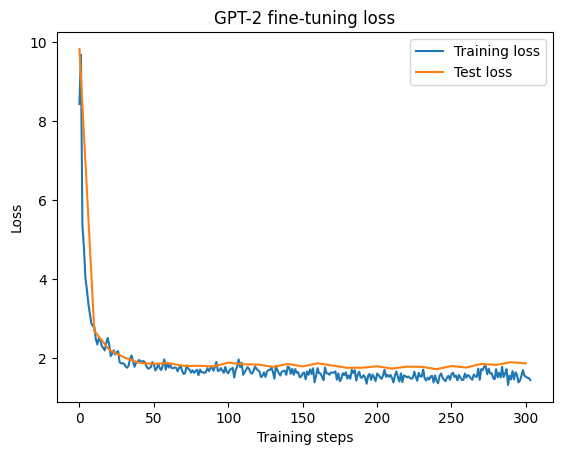

In [208]:
# 5. Plot the fine-tuning loss and MAKE SURE TO SAVE IT AND SUBMIT IT

# plot training losses with blue and test losses with red on x axis
plt.plot(losses, label="Training loss")
plt.plot(np.arange(0, len(losses), 10), test_losses, label="Test loss")
plt.title("GPT-2 fine-tuning loss")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()

plt.savefig("gpt2_loss.png")
plt.show()


In [213]:
# print a few predictions on the eval dataset to see what the model predicts

# construct a list of questions without the ground truth label
# and compare prediction of the model with the ground truth

def construct_test_samples(example):
    """
    Helper for converting input examples which have
    a separate qquestion, labels, answer options
    into a single string for testing the model.

    Arguments
    ---------
    example: dict
        Sample input from the dataset which contains the
        question, answer labels (e.g. A, B, C, D),
        the answer options for the question, and which
        of the answers is correct.

    Returns
    -------
    input_text: str, str
        Tuple: Formatted test text which contains the question,
        the forwatted answer options (e.g., 'A. <option 1> B. <option 2>' etc);
        the ground truth answer label only.
    """

    answer_options_list = list(zip(
        example["choices"]["label"],
        example["choices"]["text"]
    ))
    # join each label and text with . and space
    answer_options = [". ".join([label, text]) for label, text in answer_options_list]
    # join the list of options with spaces into single string
    answer_options_string = " ".join(answer_options)
    # combine question and answer options
    input_text = example["question"] + " " + answer_options_string
    # create the test input text which should be:
    # the input text, followed by the string "Answer: "
    # we don't need to append the ground truth answer since we are creating test inputs
    # and the answer should be predicted.
    input_text += "\nAnswer: "

    return input_text, example["answerKey"]

test_samples = [construct_test_samples(dataset["validation"][i]) for i in range(10)]
test_samples

[('A revolving door is convenient for two direction travel, but it also serves as a security measure at a what? A. bank B. library C. department store D. mall E. new york\nAnswer: ',
  'A'),
 ('What do people aim to do at work? A. complete job B. learn from each other C. kill animals D. wear hats E. talk to each other\nAnswer: ',
  'A'),
 ('Where would you find magazines along side many other printed works? A. doctor B. bookstore C. market D. train station E. mortuary\nAnswer: ',
  'B'),
 ('Where are  you likely to find a hamburger? A. fast food restaurant B. pizza C. ground up dead cows D. mouth E. cow carcus\nAnswer: ',
  'A'),
 ('James was looking for a good place to buy farmland.  Where might he look? A. midwest B. countryside C. estate D. farming areas E. illinois\nAnswer: ',
  'A'),
 ('What island country is ferret popular? A. own home B. north carolina C. great britain D. hutch E. outdoors\nAnswer: ',
  'C'),
 ("In what Spanish speaking North American country can you get a great

In [219]:
# Test the model

# set it to evaluation mode
model.eval()
predictions = []
for sample in test_samples:
    input_text = sample[0]
    input_ids = tokenizer(input_text, return_tensors="pt").to(device)
    output = model.generate(
        input_ids.input_ids,
        attention_mask = input_ids.attention_mask,
        max_new_tokens=2,
        do_sample=True,
        temperature=0.4,
    )

    prediction = tokenizer.decode(output[0], skip_special_tokens=True)
    predictions.append((input_text, prediction, sample[1]))

print("Predictions of trained model ")
for i, (input_text, prediction, true_answer) in enumerate(predictions):
    print(f"Question {i+1}:")
    print(f"Q: {input_text}")
    print(f"Predicted answer: {prediction}")
    print(f"True answer: {true_answer}")
    print("\n")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Predictions of trained model 
Question 1:
Q: A revolving door is convenient for two direction travel, but it also serves as a security measure at a what? A. bank B. library C. department store D. mall E. new york
Answer: 
Predicted answer: A revolving door is convenient for two direction travel, but it also serves as a security measure at a what? A. bank B. library C. department store D. mall E. new york
Answer:  A.
True answer: A


Question 2:
Q: What do people aim to do at work? A. complete job B. learn from each other C. kill animals D. wear hats E. talk to each other
Answer: 
Predicted answer: What do people aim to do at work? A. complete job B. learn from each other C. kill animals D. wear hats E. talk to each other
Answer:  A.
True answer: A


Question 3:
Q: Where would you find magazines along side many other printed works? A. doctor B. bookstore C. market D. train station E. mortuary
Answer: 
Predicted answer: Where would you find magazines along side many other printed works? 

### Questions
1. Provide a brief description of the CommonsenseQA dataset. What kind of task was it developed for, what do the single columns contain?

2. What loss function is computed for this training? Provide the name of the function (conceptual, not necessarily the name of a function in the code).

3. Given your loss curve, do you think your model will perform well on answering common sense questions? (Note: there is no single right answer; you need to interpret your specific plot)

4. Inspect the predictions above. On how many test questions did the model predict the right answer? Compute the accuracy.

### Answers
1. CommonsenseQA dataset consists of common sense questions (prepared via Amazon Mechnical Turk) and multiple-choice answers. It contains 12,102 questions in total. It was initially introduced by the Allen Institute with the following paper: [CommonSenseQA: A Question Answering Challenge Targeting Commonsense Knowledge](https://arxiv.org/pdf/1811.00937v2). They also provide the details of their method for generating commonsense questions at scale from ConceptNet.

  As the name suggests, this dataset is developed for developing models that can answer common sense questions. Each row consists of a `unique id`, `question`, `question concept`, `choices` and `answer key`. Choices consist of `labels` (multiple choices) and `texts` corresponding to each label. We haven't used the `question concept` field in our task but it was given as a source concept to workers during the question creation procedure.

2. Huggingface uses "language modeling loss" for its modeling - which is `Cross Entropy` loss in this case. Notice that, the negative log likelihood and cross entropy are equivalent concepts but they have slightly different implementations in DL libraries (varying input formats etc.). NLL is also equivalent to "surprisal" which is a common term used in natural language processing.

3. I don't think this model will perform well on answering common sense questions. Both training and test losses exhibit a rapid decrease initially, followed by a plateau-shaped trajectory. While there doesn't appear to be a critical overfitting issue, neither the training loss nor the test loss can go below a value of approximately 2. In the dataset paper, the authors compare the performances of various models and approaches, including a fine-tuned GPT-2 model, which achieves only around 45% accuracy on the random split dataset. This performance is significantly lower than the human level reported in the paper (89%), indicating that the complexity of the GPT-2 model may be the main limiting factor for our results.


4. Across different runs, the model generates varying predictions, resulting in instability in accuracy. It would be beneficial to take multiple samples and compute the average accuracy or, alternatively, to collect multiple sample means of accuracy and construct a confidence interval around it. In this particular case, I achieved 4 correct predictions out of 10 questions (40% accuracy), yielding a higher accuracy than random classification (20%). However, it's important to note that accuracy may fluctuate from run to run.

